# Cloud Essentials
This notebook is designed to provide an overview of some of the essential tools for distributing computations in the cloud using python. <br />


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg"  width="10%"> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Breezeicons-actions-22-arrow-left-double.svg/1024px-Breezeicons-actions-22-arrow-left-double.svg.png" width="10%"> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Breezeicons-actions-22-arrow-right-double.svg/1024px-Breezeicons-actions-22-arrow-right-double.svg.png" width="10%">  <img src="https://upload.wikimedia.org/wikipedia/commons/5/53/Cloud-blue-24.svg"  width="15%">

**Contents**
- introduction to xarray
- introduction to zarr
- introduction to dask

## Introduction to xarray
<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png"  width="40%">

for more information about xarray see [documentation](https://docs.xarray.dev/en/stable/index.html)
Xarray is a powerful tool that abstracts alot of the nuts and bolts of cloud optimized computations. It has built in integration for packages like Dask and Zarr and allows the creation of distributed computation routines very easily.

**xarray as two data structures, the DataArray and the Dataset**

#### xarray.DataArray
This structure is similar to an n-dimensional numpy array. The primary difference is that you can name the dimensions and add coordinates to the dimensions

In [8]:
import xarray as xr
import numpy as np
import pandas as pd

Let's create two (100x100) array using numpy

In [10]:
A = np.random.rand(100,100)
B = np.random.rand(100,100)

For this dummy data, let's say that we're measuring temperature (A) and salinity (B) in two dimensions - **distance and time** <br />
Let's create coordinates for these variables

In [11]:
distance = np.linspace(0, 10, 100) #meters
time = pd.to_datetime(np.linspace(pd.Timestamp('2017-01-01').value, pd.Timestamp('2018-01-01').value, 100))

Now we can create xarray.DataArray objects with this dummy data
- we name the dimensions 'distance' and 'time'
- add the cooridinates that we created
- and we can name the DataArrays which variables we are measuring

In [12]:
Ax = xr.DataArray(A, dims=['distance','time'], coords={'distance':distance, 'time':time}, name='temperature')
Bx = xr.DataArray(B, dims=['distance','time'], coords={'distance':distance, 'time':time}, name='salinity')

xarray is integrated with ipynb so you can explore it's contents interactively

In [13]:
Ax

<xarray.DataArray 'temperature' (distance: 100, time: 100)>
array([[0.94647044, 0.06829174, 0.38573798, ..., 0.53533804, 0.24931863,
        0.43067257],
       [0.4193843 , 0.44705987, 0.97701352, ..., 0.73835464, 0.80240597,
        0.80928378],
       [0.59581527, 0.59266164, 0.0827463 , ..., 0.80291092, 0.48066343,
        0.50060882],
       ...,
       [0.10868013, 0.88334326, 0.70622347, ..., 0.14780166, 0.47989293,
        0.85041095],
       [0.84264166, 0.4878493 , 0.78373839, ..., 0.57529455, 0.83625281,
        0.62122438],
       [0.17911448, 0.85257806, 0.02789296, ..., 0.41956559, 0.04780207,
        0.9625682 ]])
Coordinates:
  * distance  (distance) float64 0.0 0.101 0.202 0.303 ... 9.798 9.899 10.0
  * time      (time) datetime64[ns] 2017-01-01 ... 2018-01-01

##### Plotting

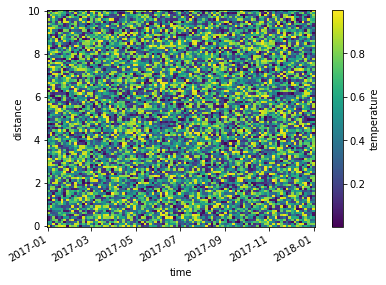

In [16]:
Ax.plot()

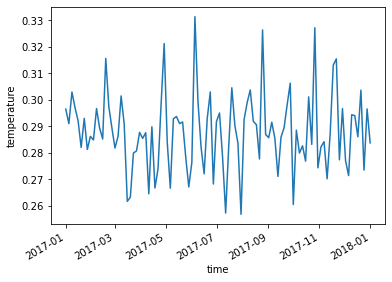

In [14]:
Ax.std('distance').plot()

##### Slicing xarray
you can slice arrays based on coordinate values <br /> for more information on slicing, see [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html)

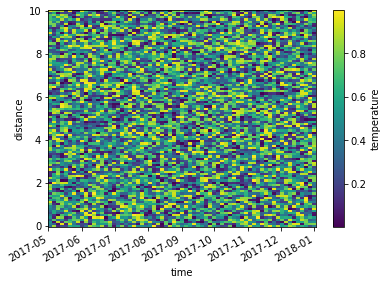

In [15]:
Ax.loc[:, pd.Timestamp('2017-05-01'):].plot()

#### xr.Dataset
Datasets are collections of data arrays, where some of the dimensions are alligned. For instance, we have two dataarrays that are measuring two variables (temperature and salinity) for the same indices of time and distance. We can group these two variables together into a single Dataset

Datasets are loosely analogous to pandas dataframes

In [19]:
ds = xr.Dataset({'temperature':Ax, 'salinity':Bx})

In [20]:
ds

<xarray.Dataset>
Dimensions:      (distance: 100, time: 100)
Coordinates:
  * distance     (distance) float64 0.0 0.101 0.202 0.303 ... 9.798 9.899 10.0
  * time         (time) datetime64[ns] 2017-01-01 ... 2018-01-01
Data variables:
    temperature  (distance, time) float64 0.9465 0.06829 ... 0.0478 0.9626
    salinity     (distance, time) float64 0.5784 0.3039 0.4149 ... 0.7514 0.744

## Introduction to Zarr
<img src="https://zarr.readthedocs.io/en/stable/_static/logo1.png"  width="20%">

Zarr is a relatively new method of saving larger than memory data that is optimized for cloud computations. The primary advantages of zarr are:
- data is chunked and compressed
- individual chunks can be randomly and concurrently accessed
- closely integrated with dask

### Chunks
let's take our dummy dataset from the xarray section and chunk it. (Which creates dask arrays) <br />***A good rule of thumb is that you want your [chunks to be ~1MB](https://docs.dask.org/en/stable/array-best-practices.html), for this example they'll be MUCH smaller***

In [37]:
chunksize = {'time':50, 'distance':50}
ds_chunked = ds.chunk(chunksize)

In [38]:
ds_chunked

<xarray.Dataset>
Dimensions:      (distance: 100, time: 100)
Coordinates:
  * distance     (distance) float64 0.0 0.101 0.202 0.303 ... 9.798 9.899 10.0
  * time         (time) datetime64[ns] 2017-01-01 ... 2018-01-01
Data variables:
    temperature  (distance, time) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    salinity     (distance, time) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

### Creating zarr store
We can now write our dataset to a zarr store and explore how the data is organized

In [39]:
_ = ds_chunked.to_zarr('test.zarr', mode='w')

looking at the contents of the zarr store, there is a directory for each data variable and the coordinates, (along with some metadata)

In [40]:
import os
os.listdir('test.zarr')

['.zgroup',
 '.zmetadata',
 'distance',
 '.zattrs',
 'time',
 'salinity',
 'temperature']

In [41]:
os.listdir('test.zarr/salinity')

['1.0', '1.1', '.zarray', '.zattrs', '0.0', '0.1']

The files that are in the directory salinity are indexed by the chunk indicies. Each of the items is the compressed n-dimensional chunk. It might be more intuit to explore the directory test.zarr yourself.

## Dask
<img src="https://assets-global.website-files.com/627ac9e2b71e64a6a0b76027/627adb72f21c6b4063e05b51_dask-header-logo.svg"  width="20%">

Dask is integrated into zarr and xarray, so now that we have a zarr store created it's very easy to utilize distributed computing through dask <br />


- Let's create a client that allows us to what the workers are doing
- the following cell should print a url, if you are on local go to this address, if you are on a remote machine, you'll need to port forward the printed port to your local machine (this can be done in VS code in the terminal window).
- the default port is usually 8787

In [43]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37019,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:46267,Total threads: 4
Dashboard: http://127.0.0.1:39941/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:34087,


let's open up our dataset that we stored to zarr

In [44]:
ds = xr.open_zarr('test.zarr')

When we ask xarray to calculate the mean, it doesn't immediately pull the array into memory, instead it creates a task graph.

In [48]:
salinity_mean = ds.salinity.mean()
salinity_mean

<xarray.DataArray 'salinity' ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

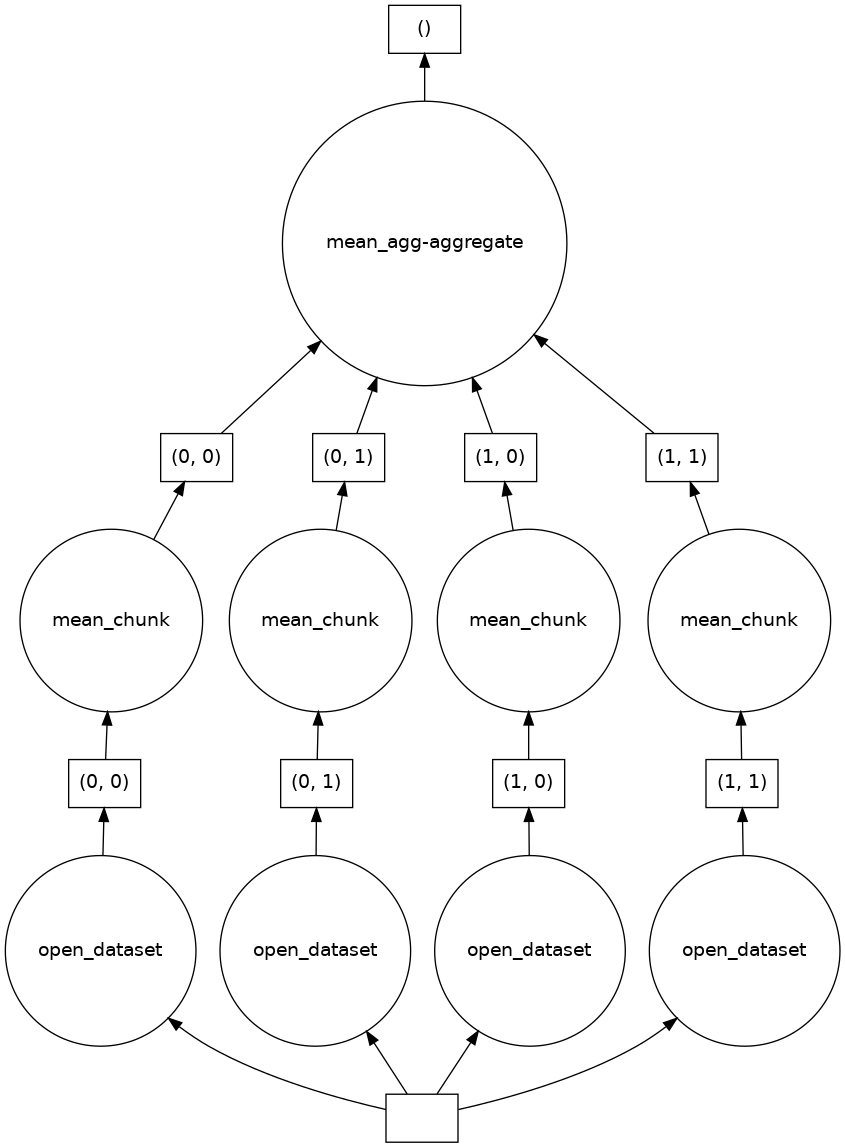

In [57]:
salinity_mean.data.visualize()

Now if we compute the task graph, it will distributely compute what we've asked it to. If you have the dask client pulled up you should see it working

In [58]:
salinity_mean.compute()

<xarray.DataArray 'salinity' ()>
array(0.50302352)

#### Map Blocks
If there isn't a built in xarray function for what you're trying to do, you can write your own with the map_blocks functionality

** Clipping Example**
Let's create an example where we clip the data to given bounds
- First, we need to create a function that does the operation that we want on a single chunk (This function actually is implemented in xarray, but this should show us how map blocks works)
- this example works on a dataarray, but you can use map blocks for datasets as well

In [86]:
def clip_chunk(A, bound_lo, bound_hi):
    '''
    clip_chunk clip dataarray A between the given bounds
    
    Parameters
    ----------
    A : xr.DataArray
        array that is clipped
    bound_low : float
        lower bound for clipping A
    bound_hi : float
        upper bound for clipping A
        
    Returns
    -------
    A_clipped : xr.DataArray
        A clipped between bounds
    '''
    
    # load A into memory as numpy array
    A_data = A.values
    
    A_clip_np = np.clip(A, bound_lo, bound_hi)
    A_clip = xr.DataArray(A_clip_np, dims=A.dims, coords=A.coords)
    
    return A_clip

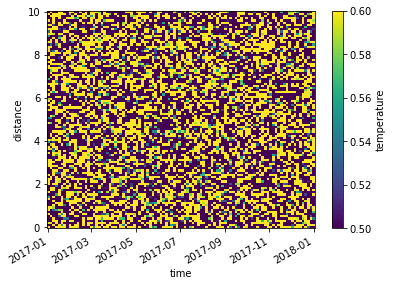

In [87]:
clip_chunk(Ax[:100,:100], 0.5, 0.6).plot()

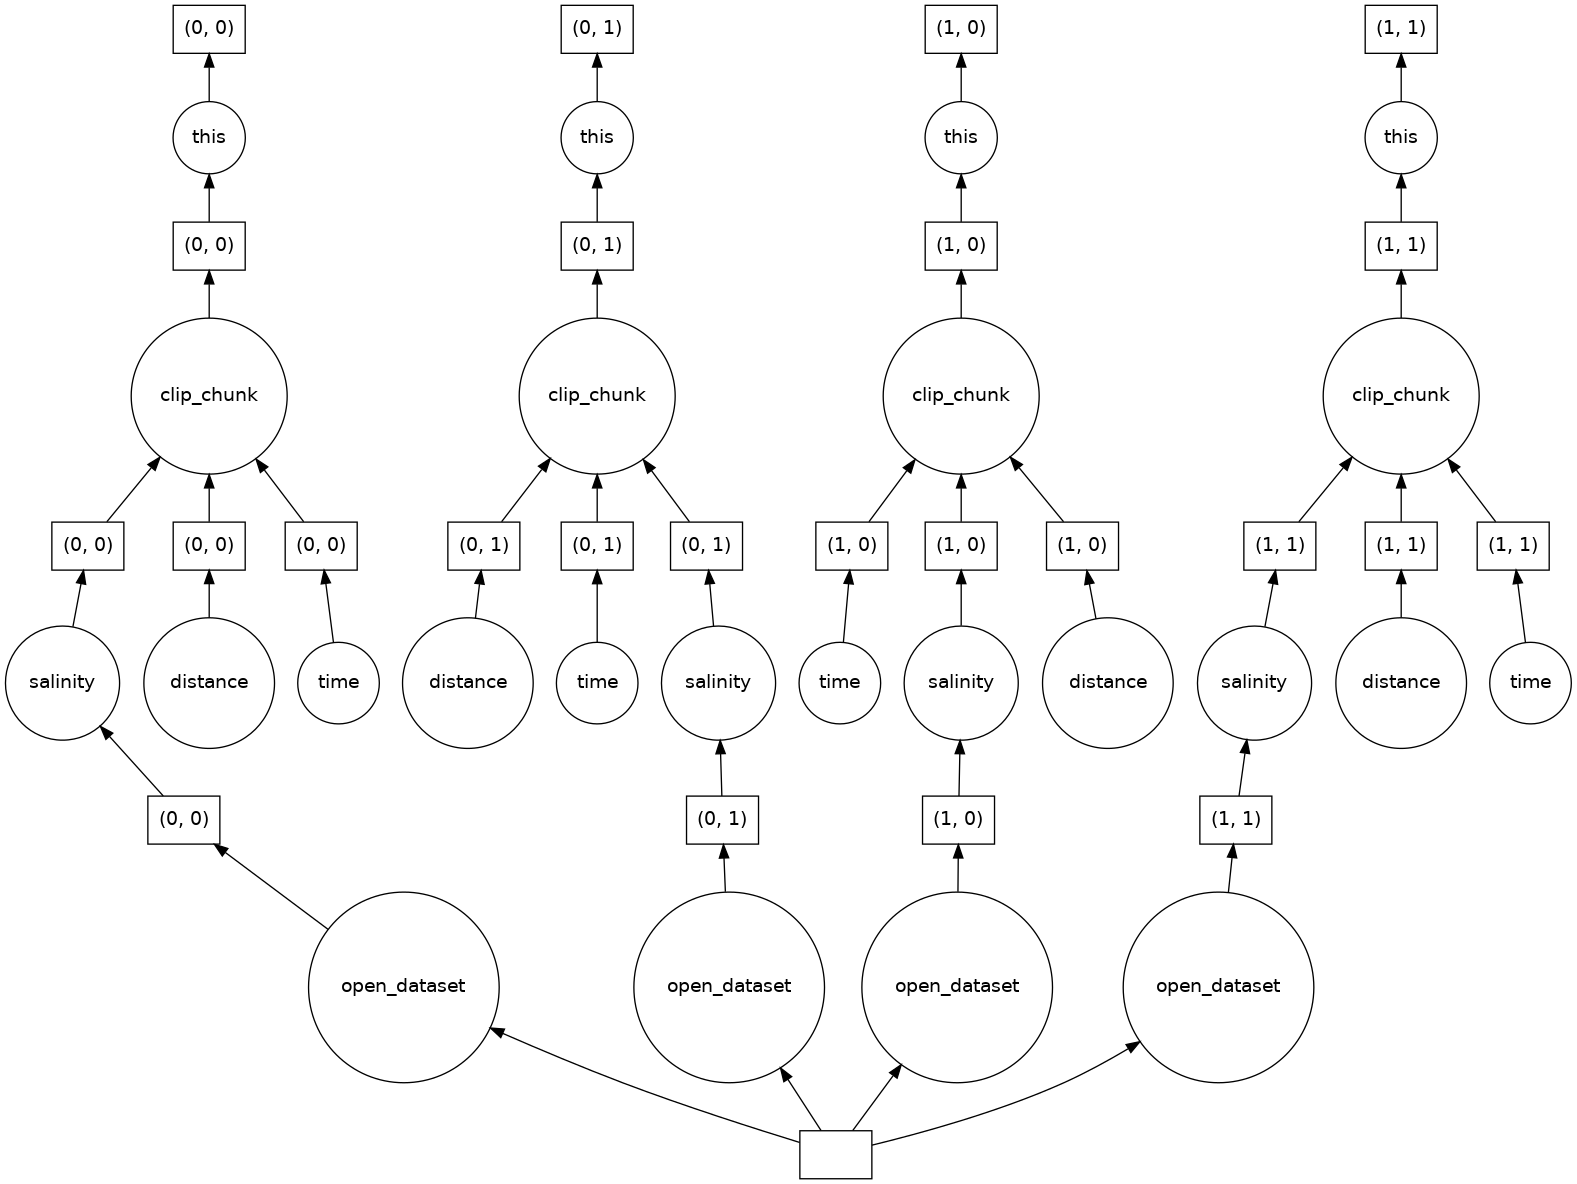

In [91]:
sal_clipped = ds.salinity.map_blocks(clip_chunk, args=([0, 0.5]), template=ds.salinity)
sal_clipped.data.visualize()

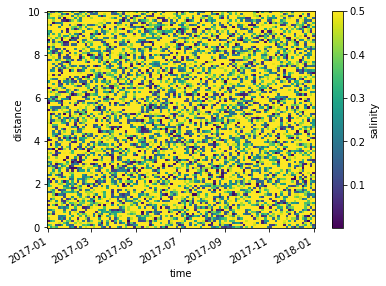

In [92]:
sal_clipped.compute().plot()